In [95]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import kneighbors_graph
from sklearn import cluster, datasets, mixture
import scipy
from scipy import linalg
from scipy.linalg import eig
from itertools import cycle, islice
import time

# Prova de Algebra Linear 

Esse notebook apresenta os métodos e resultados obtidos com o spectral clustering em comparação ao método tradicional Kmeans. Os resultados são apresentados graficamente em dois toy datasets. A seguir são apresentados resultados em um dataset de tweets sobre companhia aéreas e metrificados com completude e homogeneidade.


### Métodos de spectral clustering

Na célula abaixamos implementamos os três diferentes métodos propostos no artigo.

A seguir vamos construir os grafos de similaridade e testar cada um dos métodos, variando o tipo de grafo e o tipo de função de similaridade

In [177]:
def unnormalized_spectral_clustering(similarity_matrix, num_clusters):
    laplacian = scipy.sparse.csgraph.laplacian(similarity_matrix)
    eigvals, eigvecs = scipy.sparse.linalg.eigsh(laplacian.toarray(), k=num_clusters, which='SM')
    eigvecs = np.real_if_close(eigvecs)
    kmeans = cluster.KMeans(n_clusters=num_clusters, n_jobs=-1)
    preds = kmeans.fit_predict(eigvecs)
    return preds

def shi_spectral_clustering(similarity_matrix, num_clusters):
    laplacian = scipy.sparse.csgraph.laplacian(similarity_matrix)
    n, m = similarity_matrix.shape
    diags = similarity_matrix.sum(axis=1)
    D = scipy.sparse.spdiags(diags.flatten(), [0], m, n, format='csr')
    eigvals, eigvecs = scipy.sparse.linalg.eigsh(laplacian.toarray(), k=num_clusters, which='SM', M=D)
    eigvecs = np.real_if_close(eigvecs)
    kmeans = cluster.KMeans(n_clusters=num_clusters, n_jobs=-1)
    preds = kmeans.fit_predict(eigvecs)
    return preds

def ng_spectral_clustering(similarity_matrix, num_clusters):
    laplacian = scipy.sparse.csgraph.laplacian(similarity_matrix, normed=True)
    n, m = similarity_matrix.shape
    diags = similarity_matrix.sum(axis=1)
    D = scipy.sparse.spdiags(diags.flatten(), [0], m, n, format='csr')
    eigvals, eigvecs = scipy.sparse.linalg.eigsh(laplacian.toarray(), k=num_clusters, which='SM', M=D)
    eigvecs = np.real_if_close(eigvecs)
    T = eigvecs / np.linalg.norm(eigvecs, axis=1)[:, np.newaxis]
    kmeans = cluster.KMeans(n_clusters=num_clusters, n_jobs=-1)
    preds = kmeans.fit_predict(eigvecs)
    return preds

## Primeiros testes com toy datasets

Primeiro foram testados dois toy datasets (circles e moons) gerados aleatoriamente utilizando scikit-learn.
Esses datasets são difíceis para o kmeans por não serem linearmente separáveis. Vamos mostrar que o spectral clustering consegue resolvê-los apropriadamente.

A escolha da quantidade de vizinhos no grafo de similaridade foi feita por tentativa e erro até gerar os resultados desejados

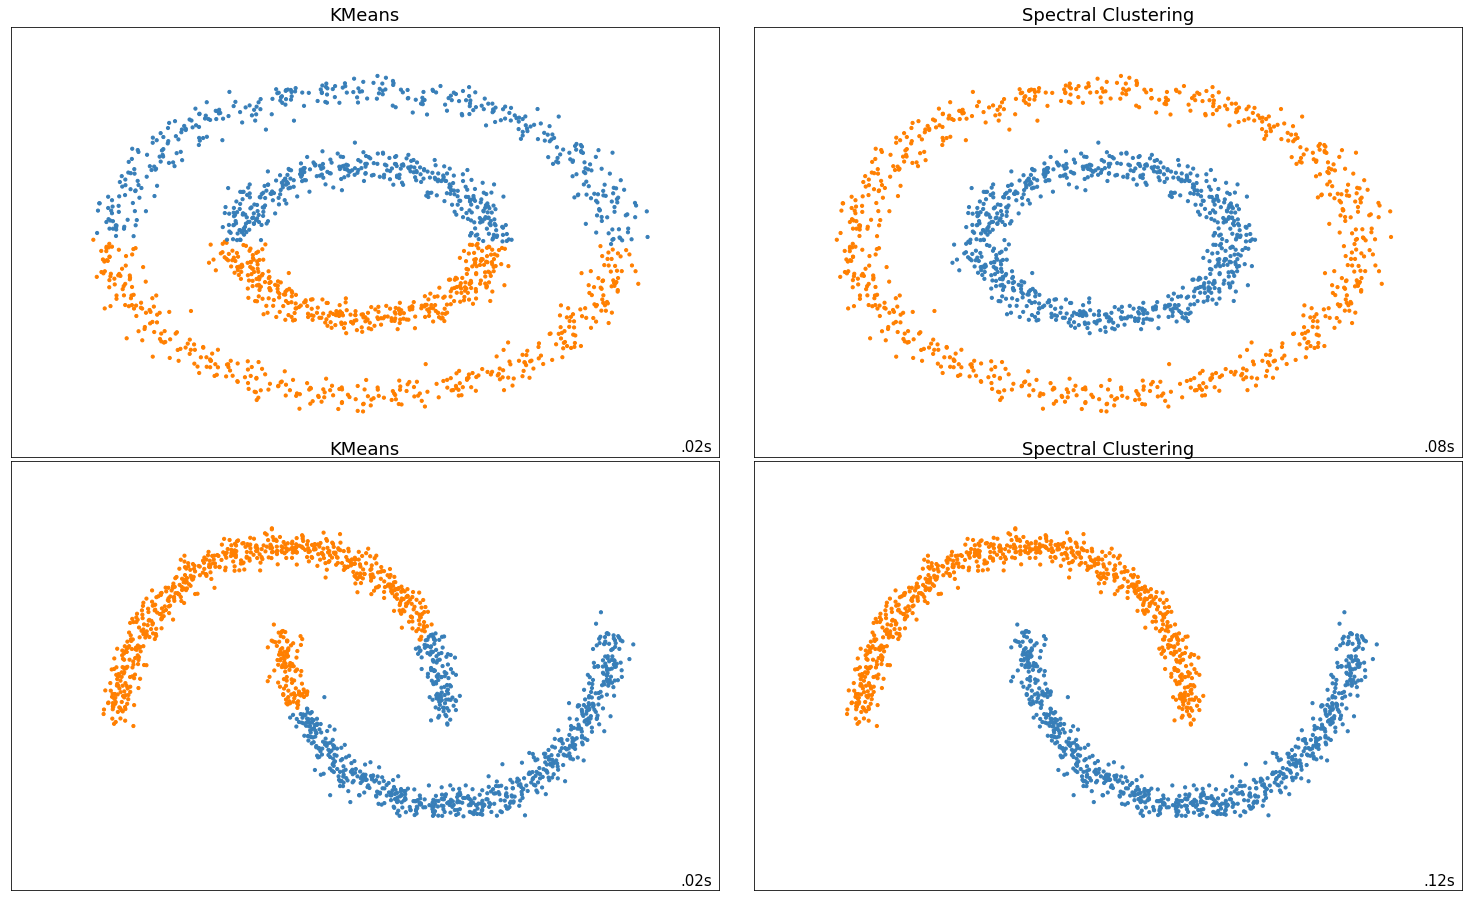

In [176]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

sets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2})
    ]
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(sets):
    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # KMEANS PART
    plt.subplot(len(sets), 2, plot_num)
    plt.title("KMeans", size=18)
    t0 = time.time()
    kmeans = cluster.KMeans(n_clusters=algo_params['n_clusters'], n_jobs=-1)
    y_pred = kmeans.fit_predict(X)
    t1 = time.time()
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1
    
    #SPECTRAL CLUSTERING PART
    plt.subplot(len(sets), 2, plot_num)
    plt.title("Spectral Clustering", size=18)
    t0 = time.time()
    similarity_matrix = kneighbors_graph(
        X, n_neighbors=10, include_self=True, mode='distance')
    
    #spectral = cluster.SpectralClustering(n_clusters=algo_params['n_clusters'], affinity='nearest_neighbors')
    #y_pred = cluster.SpectralClustering(similarity_matrix, num_clusters=algo_params['n_clusters'])
    if i_dataset == 0:
        similarity_matrix = kneighbors_graph(X, n_neighbors=80, metric='minkowski', include_self=True)
    else:
        similarity_matrix = kneighbors_graph(X, n_neighbors=155, metric='minkowski', include_self=True)
    similarity_matrix = scipy.sparse.csr_matrix(similarity_matrix)
    y_pred = unnormalized_spectral_clustering(similarity_matrix, algo_params['n_clusters'])
    t1 = time.time()
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()

Observa-se que para esses conjuntos de dados não linearmente separáveis, o Kmeans não separa bem os conjuntos, ao passo que o Spectral Clustering separa com sucesso.

A seguir vamos começar a realizar os experimentos utilizando um dataset real


### Dataset escolhido: twitter-airline-sentiment disponivel no Kaggle
https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv

O dataset foi escolhido pois ele possui texto e classificação quanto ao sentimento de cada tweet. O objetivo aqui será tentar aplicar as técnicas de Spectral Clustering para agrupar corretamente os tweets de acordo com seu conteúdo semântico

Esse notebook apresenta os resultados obtidos utilizando extração de atributos com a tecnica Tf-Idf, onde cada atributo representa a frequência de ocorrência de palavras em cada documento. As configurações de hiperparâmetros dos três métodos de Spectral Clustering foram testadas exaustivamente e os melhores resultados são apresentados e comparados com a técnica mais básica de clustering, o kmeans

In [2]:
df = pd.read_csv("./Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Colunas de interesse: id, sentimento (label) e o texto em si

In [4]:
train_ds = df[['tweet_id', 'airline_sentiment', 'text']]
train_ds.head()

,tweet_id,airline_sentiment,text
0,570306133677760513,neutral,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,@VirginAmerica plus you've added commercials t...
2,570301083672813571,neutral,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,negative,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,negative,@VirginAmerica and it's a really big bad thing...


In [5]:
train_ds['airline_sentiment'] = train_ds['airline_sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})
train_ds.head()

/home/morgan/anaconda3/envs/linear_algebra/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,tweet_id,airline_sentiment,text
0,570306133677760513,1,@VirginAmerica What @dhepburn said.
1,570301130888122368,2,@VirginAmerica plus you've added commercials t...
2,570301083672813571,1,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,0,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,0,@VirginAmerica and it's a really big bad thing...


Vamos usar o sklearn para extrair features do texto.

A maneira mais simples de fazer isso é utilizar a contagem de frequência de palavras no texto

In [6]:
count_vectorizer = CountVectorizer(max_features=5000)

feature_vector = count_vectorizer.fit(train_ds.text)
train_ds_features = count_vectorizer.transform(train_ds.text)

train_ds_features

<14640x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 222797 stored elements in Compressed Sparse Row format>

In [7]:
features = feature_vector.get_feature_names()
features[1000:2000]

['coincidence',
 'coke',
 'cold',
 'colleague',
 'colleagues',
 'collect',
 'collection',
 'college',
 'color',
 'columbia',
 'columbus',
 'com',
 'combination',
 'combine',
 'comcast',
 'come',
 'comedy',
 'comes',
 'comfort',
 'comfortable',
 'coming',
 'comm',
 'comment',
 'comments',
 'commercial',
 'commercials',
 'commitment',
 'committed',
 'common',
 'communicate',
 'communicated',
 'communication',
 'communications',
 'community',
 'comp',
 'companies',
 'companion',
 'company',
 'compared',
 'compassion',
 'comped',
 'compensate',
 'compensated',
 'compensation',
 'competent',
 'competition',
 'competitor',
 'complain',
 'complained',
 'complaint',
 'complaints',
 'complete',
 'completed',
 'completely',
 'complicated',
 'compliment',
 'complimentary',
 'computer',
 'computers',
 'con',
 'concept',
 'concern',
 'concerned',
 'concerns',
 'concert',
 'concourse',
 'condition',
 'conditions',
 'conf',
 'conference',
 'confidence',
 'confident',
 'confirm',
 'confirmation',
 'co

In [8]:
features_counts = np.sum( train_ds_features.toarray(), axis = 0 )
feature_counts = pd.DataFrame( dict( features = features,
                                  counts = features_counts ) )

feature_counts.head(5)


,features,counts
0,00,14
1,000,31
2,0016,3
3,00pm,5
4,02,6


Vamos remover stopwords

In [9]:
count_vectorizer = CountVectorizer( stop_words = "english",
                                 max_features = 5000 )
feature_vector = count_vectorizer.fit( train_ds.text )
train_ds_features = count_vectorizer.transform( train_ds.text )

features = feature_vector.get_feature_names()
features_counts = np.sum( train_ds_features.toarray(), axis = 0 )
feature_counts = pd.DataFrame( dict( features = features,
                                  counts = features_counts ) )
feature_counts.sort_values( "counts", ascending = False )[0:20]

,features,counts
4708,united,4164
1919,flight,3939
4746,usairways,3053
493,americanair,2964
4230,southwestair,2461
2617,jetblue,2395
2425,http,1155
4472,thanks,1083
996,cancelled,1065
2646,just,974


In [10]:
train_ds_features

<14640x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 122964 stored elements in Compressed Sparse Row format>

Vamos utilizar TfIdf por gerar resultados melhores

In [11]:
transformer = TfidfTransformer()
tf_idf_vector = transformer.fit(train_ds_features)
tf_idf_features = transformer.fit_transform(train_ds_features)
tf_idf_features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Metricas

Vamos utilizar como metricas do clustering: homogeinity e completeness

Vamos comparar os resultados do spectral clustering com os resultados obtidos utilizando o kmeans++

In [12]:
kmeans = cluster.KMeans(n_clusters=3)
k_means_preds = kmeans.fit_predict(tf_idf_features)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=k_means_preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=k_means_preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.03260120472013454 
Homogeneity: 0.030124309900552836


### Grafo de similaridade

Primeiro, tentamos com a distancia euclidiana, por simplicidade

### KNN graph

Os autores sugerem que o numero de vizinhos deve ser suficientemente grande para que tenhamos um grafo conexo

Vale ressaltar que para valores pequenos no numero de vizinhos as matrizes D ficaram mal-condicionadas, tornando o problema de encontrar os autovetores generalizados inviavel

Diversos valores foram testados para gerar o knn_graph, verificou-se que para os dois primeiros algoritmos, um numero maior de vizinhos teve um resultado melhor, enquanto que para o terceiro algoritmo n=50 foi o que teve o melhor resultado. Note que ele foi o que teve o menor tempo de execução dentre os três, mas os resultados ficaram marginalmente piores.

In [14]:
knn_graph = kneighbors_graph(tf_idf_features, n_neighbors=200, mode='distance', include_self=True)
G = nx.from_scipy_sparse_matrix(knn_graph)
print([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

[14640]


### Unnormalized spectral clustering

In [15]:
preds = unnormalized_spectral_clustering(similarity_matrix=knn_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.18757557178927034 
Homogeneity: 0.12968857285780938


### Shi Spectral Clustering

In [16]:
preds = shi_spectral_clustering(similarity_matrix=knn_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.18251610439867916 
Homogeneity: 0.13501819174247973


### Ng Spectral Clustering

In [17]:
knn_graph = kneighbors_graph(tf_idf_features, n_neighbors=50, mode='distance', include_self=True)
preds = ng_spectral_clustering(similarity_matrix=knn_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.17628877678241964 
Homogeneity: 0.13401032530473228


Os resultados obtidos foram melhores do que os obtidos com kmeans, mas os valores das metricas ainda estao baixos.

Vamos testar cosine distance como metrica de distancia/similaridade, uma vez que é bastante utilizada ao comparar vetores de frequencia de palavras

## Metrica de distancia: cosine distance

Diversos valores para o numero de vizinhos foram testado n=100 foi o que obteve o melhor resultado

In [18]:
knn_graph = kneighbors_graph(tf_idf_features, n_neighbors=200, mode='distance', include_self=True, metric='cosine')

### Unnormalized spectral clustering

In [19]:
preds = unnormalized_spectral_clustering(similarity_matrix=knn_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.18265001263499653 
Homogeneity: 0.1200290760383414


### Shi Spectral Clustering

In [20]:
preds = shi_spectral_clustering(similarity_matrix=knn_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.17744736102618325 
Homogeneity: 0.12821335249492244


### Ng Spectral Clustering

In [21]:
knn_graph = kneighbors_graph(tf_idf_features, n_neighbors=50, mode='distance', include_self=True, metric='cosine')
preds = ng_spectral_clustering(similarity_matrix=knn_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.14545481621349762 
Homogeneity: 0.11589473313694695


## Fully connected graph

Vamos realizar os mesmos testes utilizando um grafo fully connected

Importante notar que, apesar de mais simples em termos de hiperparâmetros, o tempo de execução e requisito de memória para esse tipo de grafo é bem maior, tendo sido necessário rodar em um servidor Xeon com 16 CPUs e 32GB de memória

**Executar o grafo inteiro não foi possivel** por lotar a memóra da máquina, por isso foi utilizado o eps-neighborhood graph

## Eps-neighborhood graph - Minkowski distance

Diversos valores de epsilon foram testados até gerar resultados satisfatórios, abaixo é exibido o código e os resultados nesse caso

In [24]:
fc_graph = metrics.pairwise.pairwise_distances(tf_idf_features.toarray(), metric='minkowski', n_jobs=-1)

In [57]:
epsilon_graph = np.copy(fc_graph)

eps = 1.3
epsilon_graph[epsilon_graph <= eps] = 1
epsilon_graph[epsilon_graph > eps] = 0

sparse_eps_graph = scipy.sparse.csr_matrix(epsilon_graph)

sparse_eps_graph

<14640x14640 sparse matrix of type '<class 'numpy.float64'>'
	with 2722148 stored elements in Compressed Sparse Row format>

### Unnormalized Spectral Clustering

In [58]:
preds = unnormalized_spectral_clustering(similarity_matrix=sparse_eps_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.10814876076020603 
Homogeneity: 0.00017087239533052523


### Shi Spectral Clustering

In [59]:
preds = shi_spectral_clustering(similarity_matrix=sparse_eps_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.1841694529531713 
Homogeneity: 0.11795778660433968


### Ng Spectral Clustering

In [60]:
#knn_graph = kneighbors_graph(tf_idf_features, n_neighbors=50, mode='distance', include_self=True, metric='cosine')
preds = ng_spectral_clustering(similarity_matrix=sparse_eps_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.09331609039437917 
Homogeneity: 0.009729176321768696


## Eps-neighborhood graph - Cosine similarity

A similaridade de coseno como métrica para gerar o eps-neighborhood exibiu muita sensibilidade. Valores pequenos para epsilon fizeram com que o algoritmo nunca convergisse, no passo de encontrar autovetores, enquanto valores maiores apresentaram resultados bem inferiores aos obtidos com outras configurações

In [184]:
fc_graph = metrics.pairwise.pairwise_kernels(tf_idf_features.toarray(), metric='cosine', n_jobs=-1)

fc_graph

array([[1.        , 0.17511192, 0.21715192, ..., 0.        , 0.        ,
        0.        ],
       [0.17511192, 1.        , 0.09713551, ..., 0.        , 0.        ,
        0.        ],
       [0.21715192, 0.09713551, 1.        , ..., 0.        , 0.        ,
        0.08976587],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.03329364,
        0.03708431],
       [0.        , 0.        , 0.        , ..., 0.03329364, 1.        ,
        0.06213987],
       [0.        , 0.        , 0.08976587, ..., 0.03708431, 0.06213987,
        1.        ]])

In [185]:
print(fc_graph.min(), fc_graph.mean(), fc_graph.max())

0.0 0.015561311410133463 1.0000000000000004


In [209]:
epsilon_graph = np.copy(fc_graph)
eps = 0.1
lower_than_eps = epsilon_graph <= eps
greater_than_eps = epsilon_graph > eps
epsilon_graph[lower_than_eps] = 0
epsilon_graph[greater_than_eps] = 1

sparse_eps_graph = scipy.sparse.csr_matrix(epsilon_graph)

sparse_eps_graph

<14640x14640 sparse matrix of type '<class 'numpy.float64'>'
	with 7536914 stored elements in Compressed Sparse Row format>

### Unnormalized Spectral Clustering

In [210]:
preds = unnormalized_spectral_clustering(similarity_matrix=sparse_eps_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.09534608088426959 
Homogeneity: 0.00015064447444013514


### Shi Spectral Clustering

In [211]:
preds = shi_spectral_clustering(similarity_matrix=sparse_eps_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.10488682302581363 
Homogeneity: 0.0944183578094327


### Ng Spectral Clustering

In [212]:
preds = ng_spectral_clustering(similarity_matrix=sparse_eps_graph, num_clusters=3)
completeness = metrics.completeness_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
homogeinity = metrics.homogeneity_score(labels_true=train_ds.airline_sentiment, labels_pred=preds)
print("Completeness: {} \nHomogeneity: {}".format(completeness, homogeinity))

Completeness: 0.05660824800556126 
Homogeneity: 0.0005309503032405696


## Resultados Finais:

|                     Algorithm                                               | Completeness | Homogeinity |
|--------------------------------------------------------------------|:------------:|-------------|
| KMeans                                                             |       0.0326 |      0.0301 |
| Spectral Clustering Unnormalized (KNN Graph - Minkowski)           |       **0.1875** |      0.1296 |
| Spectral Clustering Shi (KNN Graph - Minkowski)                    |       0.1825 |      **0.1350** |
| Spectral Clustering Ng (KNN Graph - Minkowski)                     |       0.1763 |      0.1340 |
| Spectral Clustering Unnormalized (KNN Graph - Cosine)              |       0.1826 |      0.1200 |
| Spectral Clustering Shi (KNN Graph - Cosine)                       |       0.1774 |      0.1282 |
| Spectral Clustering Ng (KNN Graph - Cosine)                        |       0.1454 |      0.1160 |
| Spectral Clustering Unnormalized (Eps-neighbors Graph - Minkowski) |       0.1081 |      0.0001 |
| Spectral Clustering Shi (Eps-neighbors Graph - Minkowski)          |       0.1842 |      0.1179 |
| Spectral Clustering Ng (Eps-neighbors Graph - Minkowski)           |       0.0933 |      0.0097 |
| Spectral Clustering Unnormalized (Eps-neighbors Graph - Cosine)    |       0.0953 |      0.0001 |
| Spectral Clustering Shi (Eps-neighbors Graph - Cosine)             |       0.1048 |      0.0944 |
| Spectral Clustering Ng (Eps-neighbors Graph - Cosine)              |       0.0566 |      0.0005 |

In [ ]:
Podemos ver que os melhores resultados obtidos foram utilizando o KNN Graph. 
O tempo de execução foi similar ao do eps-graph, apesar de que gerar a matriz de similaridade/distância completa foi bem custoso.
Ajustar os parâmetros dos grafos de similaria

## Conclusões


O algoritmo de spectral clustering conseguiu separar perfeitamente os clusters nos toy datasets, enquanto que o kmeans apresentou grande dificuldade.

Para os dados reais de agrupamento de tweets, novamente os algoritmos com spectral clustering se saíram bem melhor do que o kmeans, apesar de ainda terem valores bem baixos nas métricas utilizadas. Um fator importante a se considerar é que a extração de features foi feita de forma bem simples, inclusive pois não era o foco desse trabalho e bases de word2vec treinadas são arquivos grandes demais para a submissão desta tarefa no ambiente do moodle. Uma abordagem combinando técnicas mais elaboradas de extração de features junto ao algoritmo de spectral clustering pode gerar bons resultados para a tarefa.

Os resultados obtidos com o spectral clustering foram, de forma geral, bem superiores aos obtidos com o kmeans. Apesar disso, o ajuste dos parâmetros (função de similaridade, número de vizinhos no knn-graph, epsilon no eps-neighborhood graph) foi um trabalho bem demorado. Assim como os autores do artigo sugerem, os algoritmos são bem sensíveis a variações desses parâmetros, nesse notebook foram apresentados os melhores resultados obtidos após inúmeros experimentos para ajustá-los. Por fim, podemos ver que as técnicas de spectral clustering apresentam resultados bem interessantes para problemas não linearmente separáveis e mais estudo sobre como ajustar os parâmetros dos algoritmos é importante para desenvolvimento mais rápido utilizando tais algoritmos.